In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr_web

from scipy import stats
from scipy import optimize

C:\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


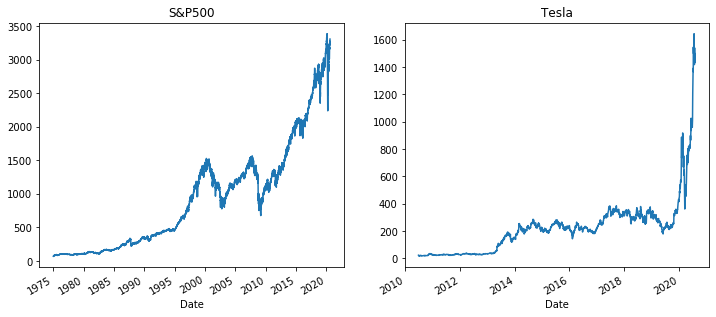

In [2]:
start_date = datetime.date(1975, 1, 1)
end_date = datetime.date.today()

# some stock and indeces to inspect
# S&P500, Tesla
sp500 = pdr_web.DataReader('^GSPC', 'yahoo', start_date, end_date)
tesla = pdr_web.DataReader('TSLA', 'yahoo', start_date, end_date)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5));

# Historical trend
sp500['Adj Close'].plot(ax=axes[0], title='S&P500');
tesla['Adj Close'].plot(ax=axes[1], title='Tesla');

Initial price: 70.2300033569336 
Estimated SP500 daily return on 1975-2020 period: 0.03328% ± 0.00002%


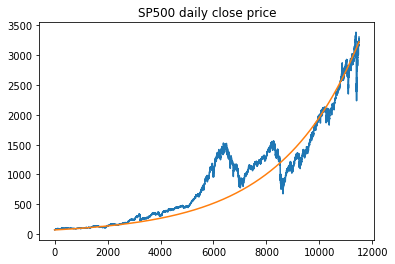

In [34]:
#
# Find average growth of sp500 index
# Does the market increases exponentially overall? 
# Is this solely due to more efficient production models and technology boost?
# NB Actually, the index price used here is not corrected by inflation!!!! 
# TODO this should be amended in order to appreciate to what extent the market 
# gains over risk-free investments (i.e. inflation)
#
_, ax2 = plt.subplots(1)
x = np.arange(start=0, stop=sp500['Adj Close'].count(), step=1)
S0 = sp500['Adj Close'].iloc[0] # index price at the beginning of the period under examination
exp_growth_func = lambda t,mu: S0 * np.exp(mu * t)
params, par_covariance = optimize.curve_fit(exp_growth_func, x, sp500['Adj Close'].values, p0=[0.0005])
ax2.plot(x, sp500['Adj Close'].values)
ax2.plot(x, exp_growth_func(x, params[0]))
ax2.set_title('SP500 daily close price')
print('Initial price:', S0,'\nEstimated SP500 daily return on 1975-2020 period: ' 
      "{:.5%}".format(params[0]), u"\u00B1", "{:.5%}".format(np.sqrt(par_covariance[0][0])) )

# TODO model the noise around the exponential growth using maybe ARIMA models


In [4]:
# stock price distribution should be log-normal
# draw and example of lognormal distribution
# x = np.arange(0, 4, 0.01)
# plt.plot(x, stats.lognorm.pdf(x, s=1, loc=1, scale=1))
# plt.title('Lognormal distribution')

Statistics on SP500 returns
count    11498.000000
mean         1.000396
std          0.010967
min          0.795331
25%          0.995482
50%          1.000538
75%          1.005588
max          1.115800
Name: Adj Close, dtype: float64

SP500 returns in the chosen period seems to be well fit by a Student's t-distribution with parameters:
dof: 3.05; location: 1.00057; scale: 0.00672


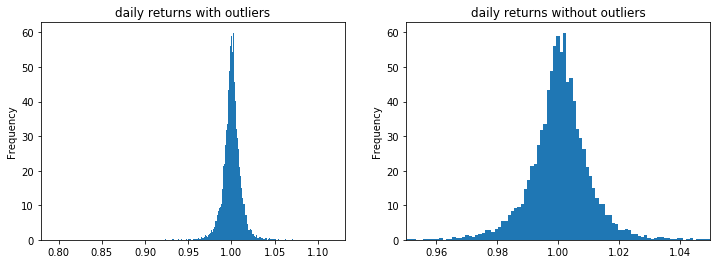

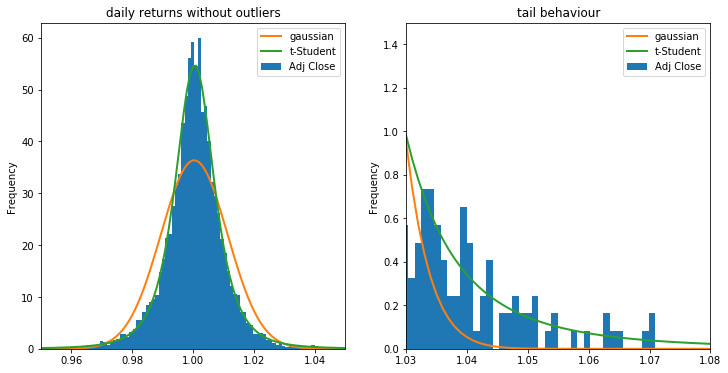

In [19]:
# analyze the daily return on sp500
sp500_returns = (sp500['Adj Close'].shift(-1) / sp500['Adj Close']).dropna()

# plot the distribution of stock prices (normalized)
fig, ax = plt.subplots(nrows=1, ncols=2 , figsize=(12,4));
sp500_returns.plot.hist(ax=ax[0], density=True, bins=300, title='daily returns with outliers');
sp500_returns.plot.hist(ax=ax[1], density=True, bins=300, xlim=(0.95, 1.05), title='daily returns without outliers');

print('Statistics on SP500 returns')
print(sp500_returns.describe());

# compare stock price return against some statistical distribution
fig_2, ax_2 = plt.subplots(nrows=1, ncols=2, figsize=(12,6));
sp500_returns.plot.hist(ax=ax_2[0], density=True, bins=300, xlim=(0.95, 1.05), title='daily returns without outliers');

# normal distribution
mu, sigma = stats.norm.fit(sp500_returns)
x = np.arange(0.9, 1.10, step=0.001)
gaussian_fit = stats.norm.pdf(x, mu, sigma)
ax_2[0].plot(x, gaussian_fit, linewidth=2, label='gaussian');
# TODO latex formula for gaussian and tail asyntotic behaviour (exponential)

# t-distribution
t_params = stats.t.fit(sp500_returns)
t_student_fit = stats.t.pdf(x, df=t_params[0], loc=t_params[1], scale=t_params[2])
ax_2[0].plot(x, t_student_fit, linewidth=2, label='t-Student');
ax_2[0].legend();
# TODO latex formula for t-distribution and tail asyntotic behaviour (power law)
print('\nSP500 returns in the chosen period seems to be well fit'
      ' by a Student\'s t-distribution with parameters:')
print("dof: {:.2f}; location: {:.5f}; scale: {:.5f}".format(*t_params))

# enlight "fat tails" and how gaussian is not suited to capture these
sp500_returns.plot.hist(ax=ax_2[1], density=True, bins=300,xlim=(1.03, 1.08), ylim=(0, 1.5));
ax_2[1].set_title('tail behaviour');
ax_2[1].plot(x, gaussian_fit, linewidth=2, label='gaussian');
ax_2[1].plot(x, t_student_fit, linewidth=2, label='t-Student');
ax_2[1].legend();


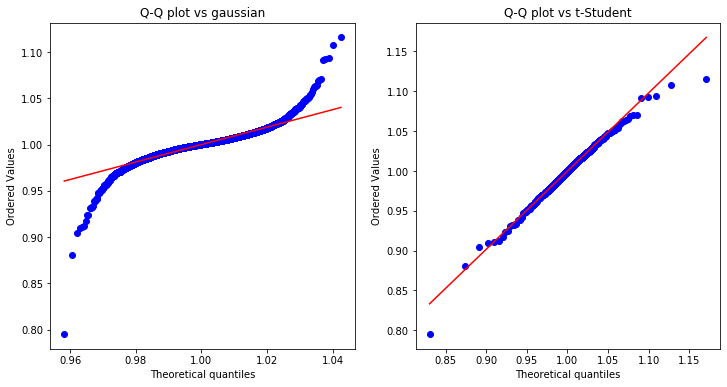

In [6]:
#
# Display quantile-quantile plot for the observed returns vs the theoretical quantiles
# of both gaussian and t-Student distribution. Heavy tails are clearly noticeble
#
fig_qq, ax_qq = plt.subplots(nrows=1, ncols=2, figsize=(12,6));

# Q-Q plot empirical vs Gaussian
stats.probplot(sp500_returns, sparams=(mu, sigma), dist="norm", plot=ax_qq[0]);
ax_qq[0].set_title('Q-Q plot vs gaussian');

# Q-Q plot empirical vs t-Student
stats.probplot(sp500_returns, sparams=t_params, dist="t", plot=ax_qq[1]);
ax_qq[1].set_title('Q-Q plot vs t-Student');


Compare p-values against confidence interval (typically 0.05 or 0.01)
KS test p-value for normal distribution: 1.09e-63
KS test p-value for Student t-distribution: 0.168


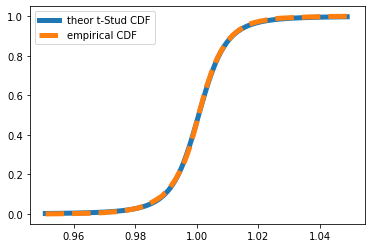

In [7]:
#
# Based on the fit of the previous section, 
# do some hypothesis testing on index price distribution.
# Is it actually accurate to state that the daily returns of sp500 follow a t-Student distribution?
#

# NB: for the moment, use a subset of data, neglecting the rarest and most peculiar outliers
obs_data = sp500_returns[(sp500_returns >= 0.95) & (sp500_returns <= 1.05)];

#
# KOLMOGOROV-SMIRNOV test: it is based on empirical vs theoretical CDFs
#
print('Compare p-values against confidence interval (typically 0.05 or 0.01)')

# Use KS statistics against normal distribution
ks_norm_stat, ks_norm_pval = stats.kstest(obs_data, lambda x : stats.norm.cdf(x, mu, sigma))
print('KS test p-value for normal distribution:', "{:.2e}".format(ks_norm_pval))

# Use KS statistics against Student's t distribution
ks_tStud_stat, ks_tStud_pval = stats.kstest(obs_data, lambda x : stats.t.cdf(x, *t_params))
print('KS test p-value for Student t-distribution:', "{:.3f}".format(ks_tStud_pval))

# Compare empirical vs theor CDFs
x_min = np.min(obs_data.values); x_max = np.max(obs_data.values);
x = np.arange(x_min, x_max, step=0.001);
plt.plot(x,stats.t.cdf(x, *t_params),label='theor t-Stud CDF', linewidth=5); # theor t-Student CDF

values_per_bin, bin_edges = np.histogram(obs_data, bins=1000)
cdf = np.cumsum(values_per_bin);
plt.plot(bin_edges[1:], cdf/cdf[-1],'--', label='empirical CDF', linewidth=5); # empirical CDF
plt.legend();

# Student distribution seems to actually fit well index returns (NB extreme outliers were removed)


In [8]:
# TODO Do some test specifically on normality: e.g. Jacques-Brera, Shapiro-Wilk...

# TODO Perform Pearson's Chi Squared test against normal distribution
# get bin-frequencies of data, for the moment we restrict the range of values,
# neglecting the most rare and peculiar outliers
# norm_test_chi_sq, norm_test_p_val = stats.chisquare(f_obs=obs_counts, f_exp=theor_counts_norm)

# TODO Perform Pearson's Chi Squared test against Student's t-distribution
# tStud_test_chi_sq, tStud_test_p_val = stats.chisquare(f_obs=obs_counts, f_exp=theor_counts_student)
